In [1]:
from pyspark.sql import SparkSession
import os
import tempfile
import urllib.request

# Create Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("lin-reg") \
    .getOrCreate()

# Correct raw GitHub URL and safe local path (no leading slash in filename)
url = "https://raw.githubusercontent.com/Apress/machine-learning-with-pyspark/master/chapter_4_Linear_Regression/Linear_regression_dataset.csv"
local_path = os.path.join(tempfile.gettempdir(), "Linear_regression_dataset.csv")

# Download dataset (overwrites if already present)
urllib.request.urlretrieve(url, local_path)

# Read with Spark
df = spark.read.csv(local_path, header=True, inferSchema=True)

# Quick sanity check
print(f"Loaded file: {local_path} (exists={os.path.exists(local_path)})")
df.show(5)

Loaded file: /tmp/Linear_regression_dataset.csv (exists=True)
+-----+-----+-----+-----+-----+------+
|var_1|var_2|var_3|var_4|var_5|output|
+-----+-----+-----+-----+-----+------+
|  734|  688|   81|0.328|0.259| 0.418|
|  700|  600|   94| 0.32|0.247| 0.389|
|  712|  705|   93|0.311|0.247| 0.417|
|  734|  806|   69|0.315| 0.26| 0.415|
|  613|  759|   61|0.302| 0.24| 0.378|
+-----+-----+-----+-----+-----+------+
only showing top 5 rows


In [11]:
!pip install seaborn

# Exploratory shenaningans

In [3]:
df.count(), df.columns

(1232, ['var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'output'])

In [5]:
df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)



In [6]:
df.describe().show()

+-------+-----------------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|            var_1|            var_2|             var_3|               var_4|               var_5|             output|
+-------+-----------------+-----------------+------------------+--------------------+--------------------+-------------------+
|  count|             1232|             1232|              1232|                1232|                1232|               1232|
|   mean|715.0819805194806|715.0819805194806| 80.90422077922078|  0.3263311688311693| 0.25927272727272715|0.39734172077922014|
| stddev| 91.5342940441652|93.07993263118064|11.458139049993724|0.015012772334166148|0.012907228928000298|0.03326689862173776|
|    min|              463|              472|                40|               0.277|               0.214|              0.301|
|    max|             1009|             1103|               116|               0.373|               0.294|     

In [8]:
df.head(5)

[Row(var_1=734, var_2=688, var_3=81, var_4=0.328, var_5=0.259, output=0.418),
 Row(var_1=700, var_2=600, var_3=94, var_4=0.32, var_5=0.247, output=0.389),
 Row(var_1=712, var_2=705, var_3=93, var_4=0.311, var_5=0.247, output=0.417),
 Row(var_1=734, var_2=806, var_3=69, var_4=0.315, var_5=0.26, output=0.415),
 Row(var_1=613, var_2=759, var_3=61, var_4=0.302, var_5=0.24, output=0.378)]

In [10]:
from pyspark.sql.functions import corr

df.select(corr("var_1", "output")).show()

+-------------------+
|corr(var_1, output)|
+-------------------+
| 0.9187399607627283|
+-------------------+



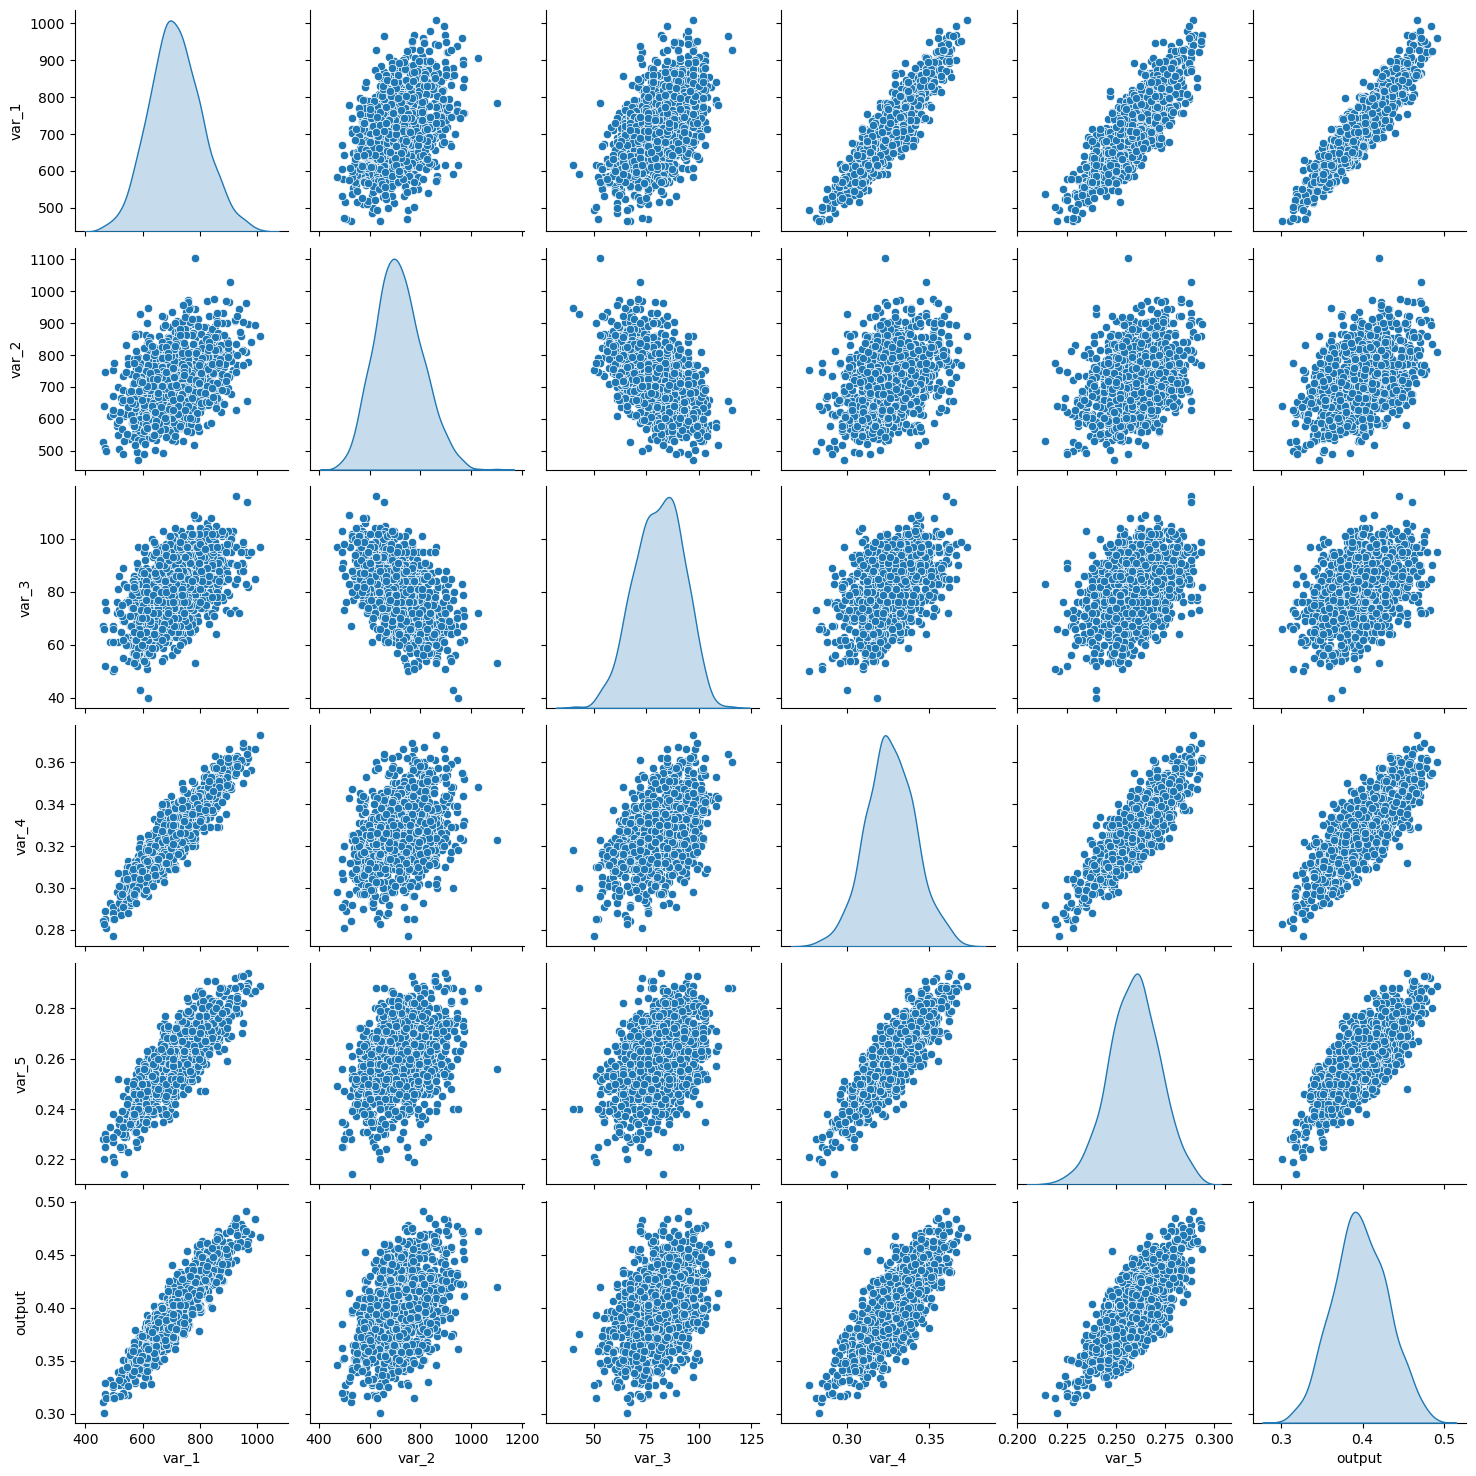

In [12]:
import seaborn as sns

sns.pairplot(df.toPandas(), diag_kind="kde")

# Feature engineering

In [14]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [15]:
vec_assembler = VectorAssembler(inputCols=["var_1", "var_2", "var_3", "var_4","var_5"], outputCol="features")
features_df = vec_assembler.transform(df)
features_df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
features_df.select("features").show(5, truncate=False)

+------------------------------+
|features                      |
+------------------------------+
|[734.0,688.0,81.0,0.328,0.259]|
|[700.0,600.0,94.0,0.32,0.247] |
|[712.0,705.0,93.0,0.311,0.247]|
|[734.0,806.0,69.0,0.315,0.26] |
|[613.0,759.0,61.0,0.302,0.24] |
+------------------------------+
only showing top 5 rows


In [17]:
model_df = features_df.select("features", "output")
model_df.show(5, truncate=False)

+------------------------------+------+
|features                      |output|
+------------------------------+------+
|[734.0,688.0,81.0,0.328,0.259]|0.418 |
|[700.0,600.0,94.0,0.32,0.247] |0.389 |
|[712.0,705.0,93.0,0.311,0.247]|0.417 |
|[734.0,806.0,69.0,0.315,0.26] |0.415 |
|[613.0,759.0,61.0,0.302,0.24] |0.378 |
+------------------------------+------+
only showing top 5 rows


In [18]:
model_df.count(), model_df.columns

(1232, ['features', 'output'])

# Splitting the data into training and test sets

In [20]:
train_df, test_df = model_df.randomSplit([0.7, 0.3], seed=42)

train_df.count(), test_df.count()

(913, 319)

In [21]:
# Build & Train the Linear Regression Model

In [22]:
from pyspark.ml.regression import LinearRegression

lin_reg = LinearRegression(featuresCol="features", labelCol="output")
lr_model = lin_reg.fit(train_df)

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [0.00033234369011349415,5.2026393282373525e-05,0.0001906993632242903,-0.6156617618887359,0.48403289012782585]
Intercept: 0.18248726674426738


In [ ]:
# Evaluate the Model on Training Data

In [23]:
training_predictions = lr_model.evaluate(train_df)
training_predictions.r2, training_predictions.meanAbsoluteError, training_predictions.meanSquaredError

(0.8666409386017968, 0.009624812418041832, 0.00014312933805064304)

In [ ]:
# Evaluate the Model on Test Data

In [25]:
test_predictions = lr_model.evaluate(test_df)
test_predictions.r2, test_predictions.meanAbsoluteError, test_predictions.meanSquaredError

(0.8751967254722545, 0.009604387181059161, 0.0001493936342998778)

In [26]:
# Evaluate the Model using plots

In [27]:
import seaborn as sns

<Axes: xlabel='prediction', ylabel='residuals'>

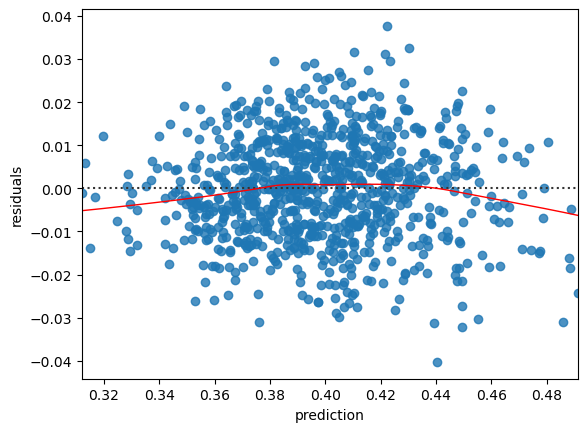

In [33]:
#residuals vs fitted
train_results = lr_model.evaluate(train_df)

sns.residplot(x=train_results.predictions.select("prediction").toPandas(),
              y=train_results.residuals.select("residuals").toPandas(),
              lowess=True,
              line_kws={'color': 'red', 'lw': 1})

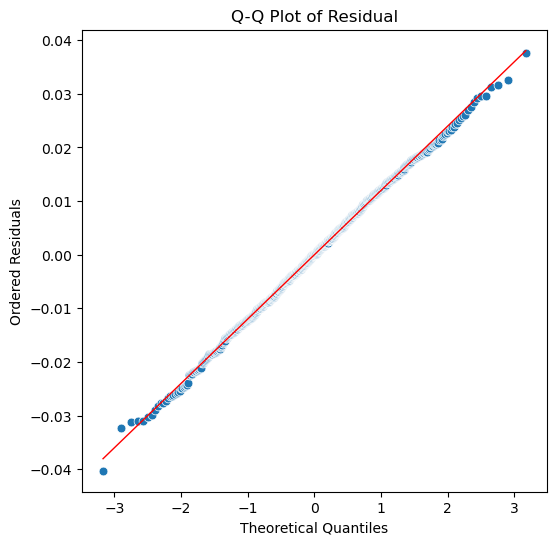

In [34]:
# residuals qq plot
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

# extract residuals as numpy array
residuals = train_results.residuals.select("residuals").toPandas()["residuals"].values

# get theoretical quantiles, ordered residuals and fit parameters
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm", fit=True)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=osm, y=osr, s=40)
# plot the reference line from the fit
x_line = np.array([osm.min(), osm.max()])
y_line = slope * x_line + intercept
sns.lineplot(x=x_line, y=y_line, color="red", lw=1)

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Residuals")
plt.title("Q-Q Plot of Residual")
plt.show()